# Validation for quantile delta change 

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -19.26
example_lon = 146.8
example_month = 6

In [25]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/rcp85/r1i1p1/day/pr/v20120407/pr-ssr-qdc-multiplicative-monthly-adjustment-factors_CanESM2_rcp85_r1i1p1_20560101-20851231_wrt_19860101-20051231.nc"
qq_file = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/rcp85/r1i1p1/day/pr/v20120407/pr-ssr_day_CanESM2_rcp85_r1i1p1_AUS-r005_20560101-20851231_qdc-multiplicative-monthly_AGCD-19810101-20101231_historical-19860101-20051231.nc"
example_lat = -19.26
example_lon = 146.8
example_month = 6
hist_units = "mm day-1"
ref_units = "mm day-1"
target_units = "mm day-1"
output_units = "mm day-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
hist_files = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/historical/r1i1p1/day/pr/v20120410/pr-ssr_day_CanESM2_historical_r1i1p1_19860101-20051231.nc"
ref_files = "/g/data/wp00/users/dbi599/QQ-CMIP5/CanESM2/rcp85/r1i1p1/day/pr/v20120407/pr-ssr_day_CanESM2_rcp85_r1i1p1_20560101-20851231.nc"
target_files = "/g/data/wp00/data/AGCD/precip-ssr_AGCD_r005_19810101-20101231_daily.nc"
target_q_file = (
    "/g/data/wp00/data/AGCD/precip-ssr-quantiles_AGCD_r005_1981-2010_daily.nc"
)
hist_time_bounds = "1986-01-01 2005-12-31"
ref_time_bounds = "2056-01-01 2085-12-31"
target_time_bounds = "1981-01-01 2010-12-31"


In [26]:
# Required parameters
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'target_q_file' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [27]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [28]:
point_selection = {'lat': example_lat, 'lon': example_lon}

In [29]:
plot_config = {}
if hist_var == 'tasmin':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
elif hist_var == 'tasmax':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var == 'pr':
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

## Read data

In [30]:
ds_adjust = xr.open_dataset(adjustment_file)

In [31]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)
ds_hist[hist_var]

<xarray.DataArray 'pr' (time: 7300, lat: 64, lon: 128)>
dask.array<xarray-pr, shape=(7300, 64, 128), dtype=float64, chunksize=(7300, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1986-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           at surface; includes both liquid and solid phases from...
    units:             mm day-1
    original_name:     PCP
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-04-13T23:04:41Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [32]:
da_hist_point = ds_hist[hist_var].sel(point_selection, method='nearest')
hist_q_point_annual = utils.get_quantiles(da_hist_point, ds_adjust['quantiles'].data, timescale='annual')
da_hist_point_month = da_hist_point[da_hist_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  0.2s


In [33]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)
ds_ref[ref_var]

<xarray.DataArray 'pr' (time: 10950, lat: 64, lon: 128)>
dask.array<xarray-pr, shape=(10950, 64, 128), dtype=float64, chunksize=(10950, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2056-01-01 12:00:00 ... 2085-12-31 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           at surface; includes both liquid and solid phases from...
    units:             mm day-1
    original_name:     PCP
    cell_methods:      time: mean (interval: 15 minutes)
    cell_measures:     area: areacella
    history:           2011-04-10T10:30:39Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [34]:
da_ref_point = ds_ref[ref_var].sel(point_selection, method='nearest')
ref_q_point_annual = utils.get_quantiles(da_ref_point, ds_adjust['quantiles'].data, timescale='annual')
da_ref_point_month = da_ref_point[da_ref_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  0.3s


In [35]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)
ds_target[target_var]

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float64, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1981-01-01T09:00:00 ... 2010-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm day-1

In [36]:
da_target_point = ds_target[target_var].sel(point_selection, method='nearest')
target_q_point_annual = utils.get_quantiles(da_target_point, ds_adjust['quantiles'].data, timescale='annual')
da_target_point_month = da_target_point[da_target_point['time'].dt.month == example_month]

[########################################] | 100% Completed |  3min 46.8s


In [37]:
target_q = xr.open_dataset(target_q_file)
target_q

<xarray.Dataset>
Dimensions:    (quantiles: 100, lon: 886, lat: 691, month: 12)
Coordinates:
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
  * lon        (lon) float64 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip     (quantiles, month, lat, lon) float64 ...
Attributes:
    history:  Fri Mar 17 18:37:20 2023: /g/data/xv83/dbi599/miniconda3/envs/q...

In [38]:
ds_qq = xr.open_dataset(qq_file)

In [39]:
da_qq_point = ds_qq[target_var].sel(point_selection, method='nearest')
qq_q_point_annual = utils.get_quantiles(da_qq_point, ds_adjust['quantiles'].data, timescale='annual')
da_qq_point_month = da_qq_point[da_qq_point['time'].dt.month == example_month]

In [40]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

In [41]:
print(lat_min_qq, lat_max_qq, lon_min_qq, lon_max_qq)

-44.5 -10.0 112.0 156.25


## Quantile mapping

In [42]:
def quantile_month_plot(da, ax, cmap_type, levels=None, extend='both', point=None, title=None):
    """Create two dimensional month/quantile plot"""
    
    assert cmap_type in ['regular', 'diverging']
    
    quantiles = da.sel(point_selection, method='nearest')
    
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose('month', 'quantiles').plot(ax=ax, cmap=cmap, extend=extend, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

In [43]:
def quantile_spatial_plot(
    da, month, cmap_type, lat_bounds=None, lon_bounds=None, levels=None,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
        
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
        
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        **kwargs,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

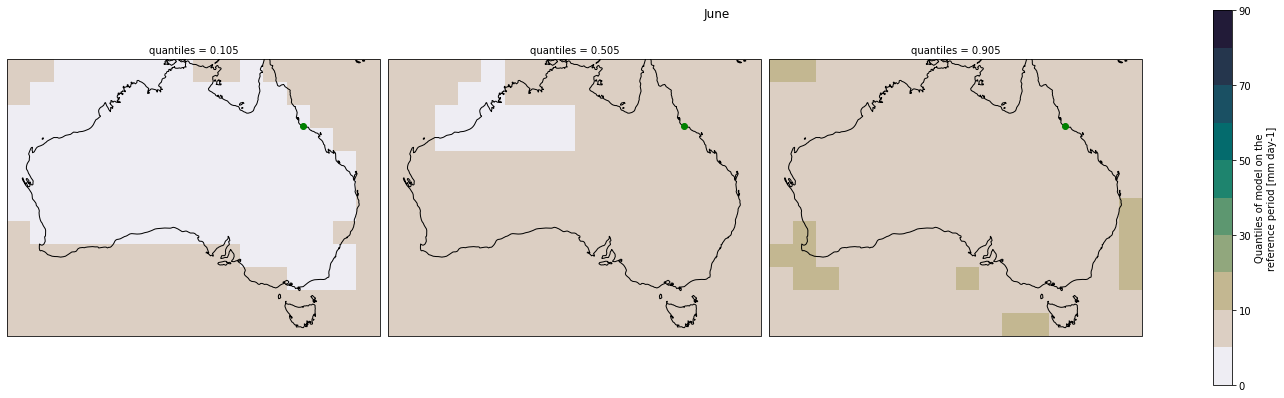

In [44]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        'regular',
        levels=plot_config['general_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

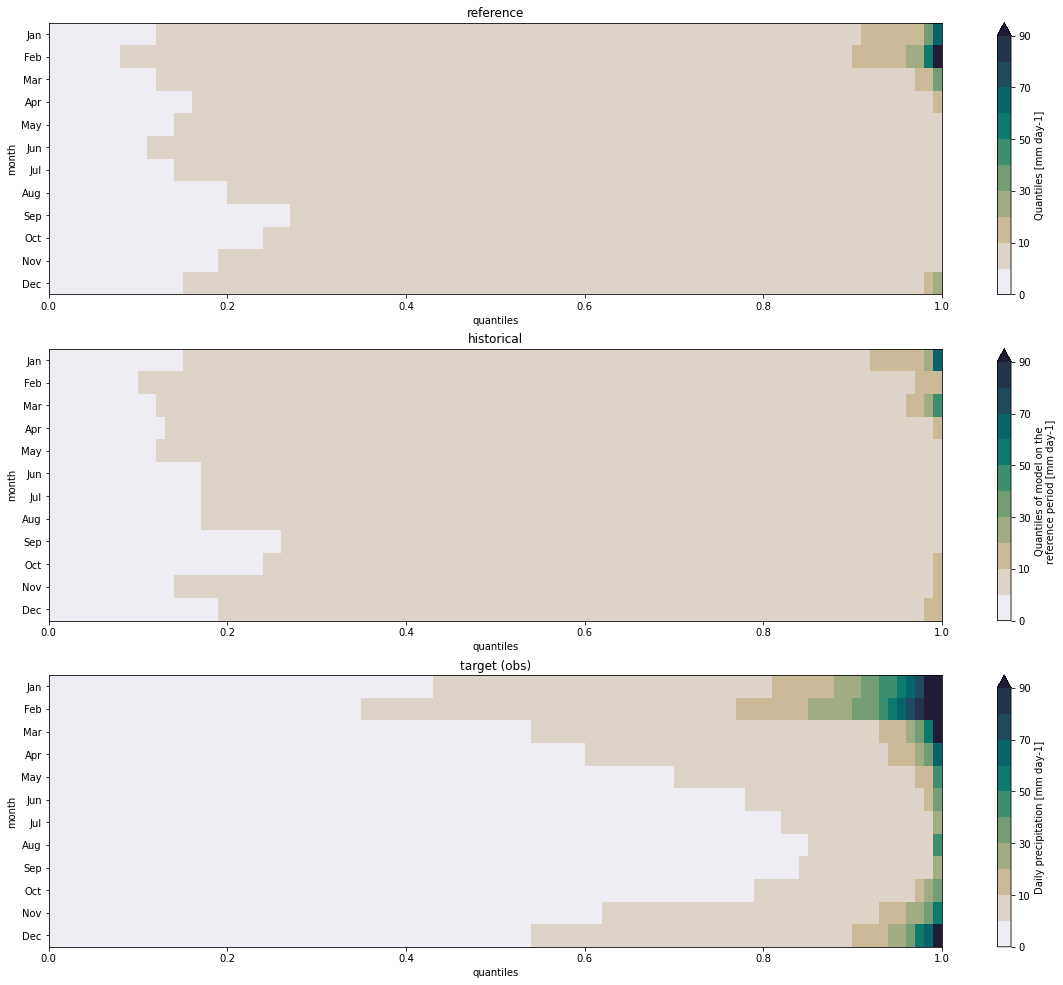

In [46]:
fig = plt.figure(figsize=[20, 17])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax1,
    'regular',
    levels=plot_config['general_levels'],
    title='reference',
    extend='max',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax2,
    'regular',
    levels=plot_config['general_levels'],
    title='historical',
    extend='max',
)

quantile_month_plot(
    target_q[target_var],
    ax3,
    'regular',
    levels=plot_config['general_levels'],
    title='target (obs)',
    extend='max',
)

plt.show()

[########################################] | 100% Completed |  1min  1.7s
[########################################] | 100% Completed |  0.3s


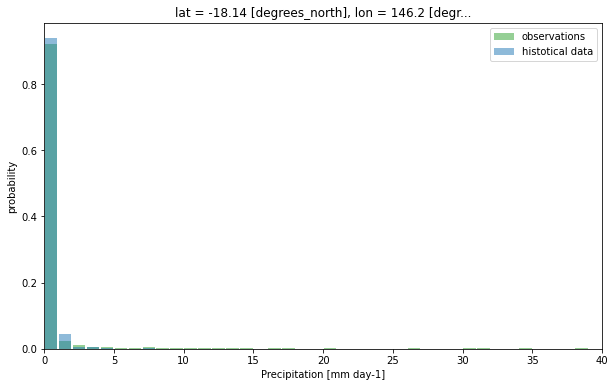

In [69]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)

da_target_point_month.plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)

da_hist_point_month.plot.hist(
    bins=bins,
    density=True,
    label='histotical data',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(0, 40)
plt.legend()
plt.show()

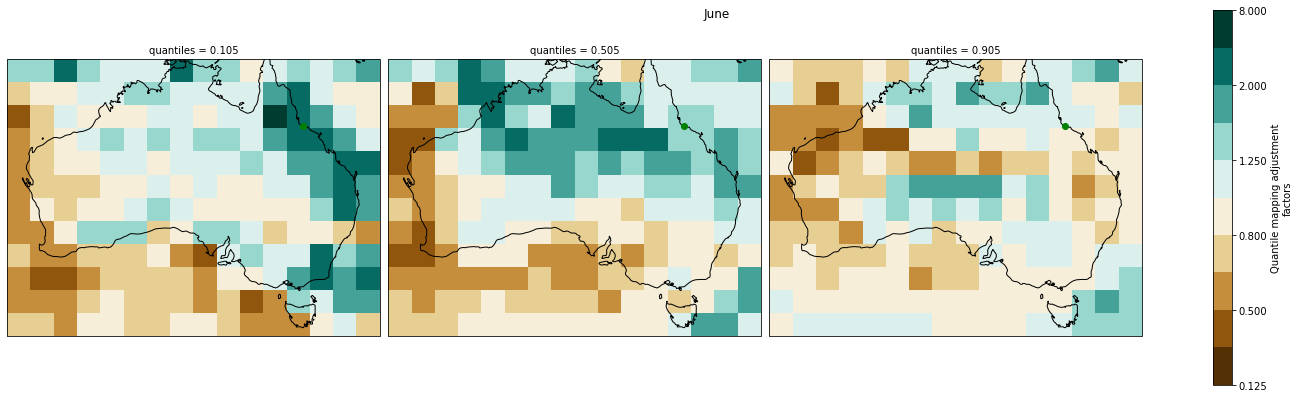

In [48]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        'diverging',
        levels=plot_config['af_levels'],
        lat_bounds=[lat_min_qq, lat_max_qq],
        lon_bounds=[lon_min_qq, lon_max_qq],
    )

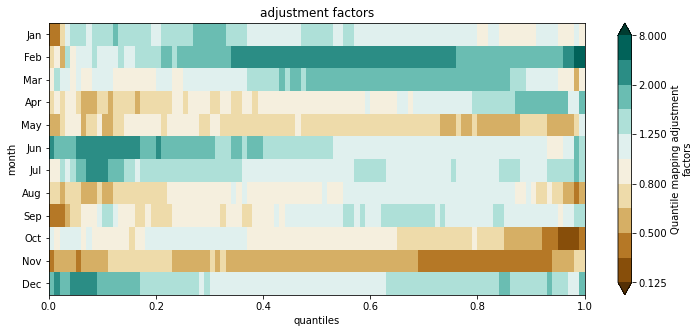

In [49]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors'
)

plt.show()

## QQ-scaled data

In [50]:
model_sel = {'lat': slice(lat_min_qq, lat_max_qq), 'lon': slice(lon_min_qq, lon_max_qq)}

In [51]:
hist_clim = ds_hist[hist_var].mean('time', keep_attrs=True)
ref_clim = ds_ref[ref_var].mean('time', keep_attrs=True)
target_clim = ds_target[target_var].mean('time', keep_attrs=True)
qq_clim = ds_qq[target_var].mean('time', keep_attrs=True)

In [52]:
if len(hist_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(hist_clim, qq_clim, "bilinear")
    hist_clim = regridder(hist_clim)

if len(ref_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(ref_clim, qq_clim, "bilinear")
    ref_clim = regridder(ref_clim)
    
if len(target_clim['lat']) != len(qq_clim['lat']):
    regridder = xe.Regridder(target_clim, qq_clim, "bilinear")
    target_clim = regridder(target_clim)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key i

In [53]:
hist_ref_mean_diff = ref_clim - hist_clim
hist_ref_mean_diff = hist_ref_mean_diff.compute()

[########################################] | 100% Completed |  1.7s


In [54]:
qq_mean_change = qq_clim - target_clim
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed |  2min  5.9s


In [55]:
difference = qq_mean_change - hist_ref_mean_diff

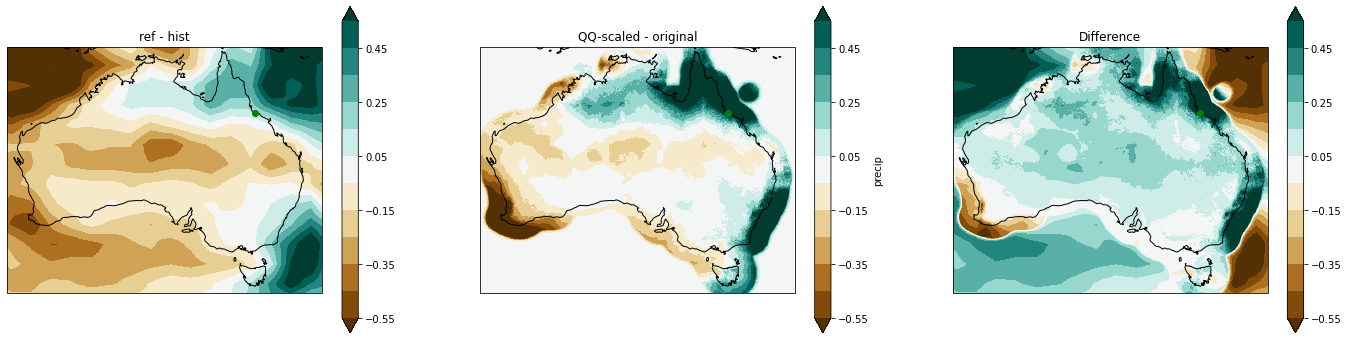

In [56]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
hist_ref_mean_diff.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax1.set_title('ref - hist')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax2.set_title('QQ-scaled - original')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
difference.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=plot_config['difference_levels'],
    extend='both'
)
ax3.set_title('Difference')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.show()

[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  4.6s


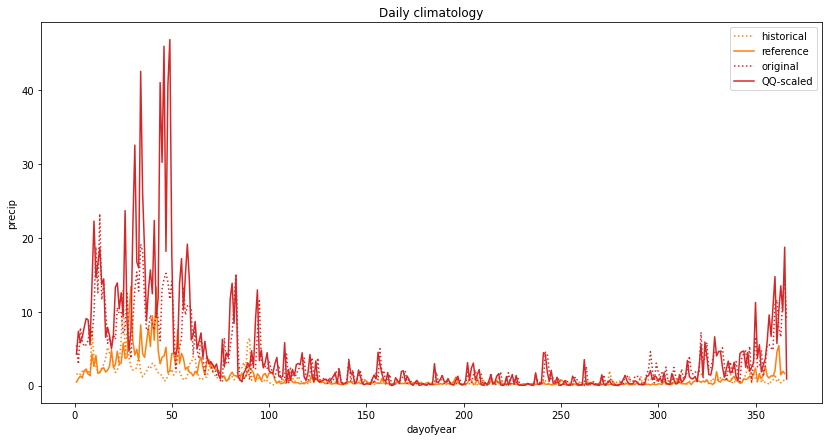

In [57]:
fig, ax = plt.subplots(figsize=[14, 7])
da_hist_point.groupby("time.dayofyear").mean().plot(label="historical", color='tab:orange', linestyle=':')
da_ref_point.groupby("time.dayofyear").mean().plot(label="reference", color='tab:orange')
da_target_point.groupby("time.dayofyear").mean().plot(label="original", color='tab:red', linestyle=':')
da_qq_point.groupby("time.dayofyear").mean().plot(label="QQ-scaled", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed |  0.2s


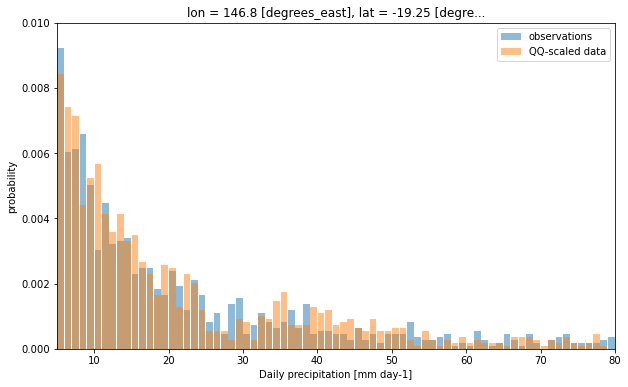

In [68]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(0, 150, 1)
    
da_target_point.plot.hist(
    bins=bins,
    density=True,
    label='observations',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
da_qq_point.plot.hist(
    bins=bins,
    density=True,
    label='QQ-scaled data',
    facecolor='tab:orange',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.ylim(0, 0.01)
plt.xlim(5, 80)
plt.legend()
plt.show()

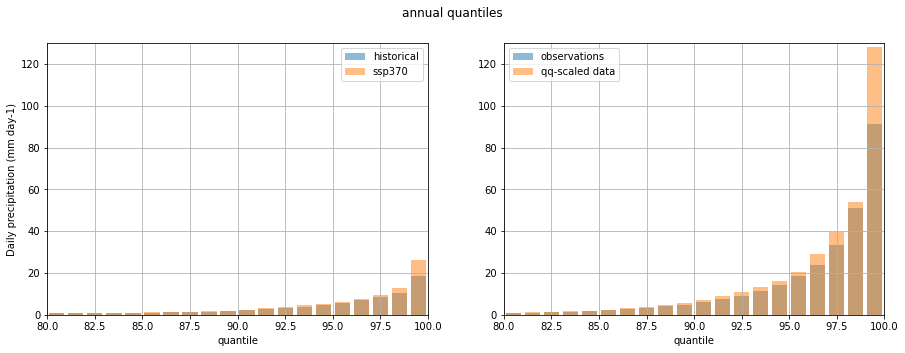

In [66]:
fig = plt.figure(figsize=[15, 5])
ax1 = fig.add_subplot(122)
ax2 = fig.add_subplot(121)

obs_data = target_q_point_annual.values
qq_data = qq_q_point_annual.values
hist_data = hist_q_point_annual.values
future_data = ref_q_point_annual.values
quantiles = target_q_point_annual['quantiles'].data * 100
    
ax1.bar(quantiles, obs_data, alpha=0.5, label='observations')
ax1.bar(quantiles, qq_data, alpha=0.5, label='qq-scaled data')
ax2.bar(quantiles, hist_data, alpha=0.5, label='historical')
ax2.bar(quantiles, future_data, alpha=0.5, label='ssp370')

ylabel = f"""{da_target_point.attrs['long_name']} ({da_target_point.attrs['units']})"""

ax1.set_xlim(80, 100)
ax1.set_ylim(0, 130)
ax1.grid()
ax1.legend()
ax1.set_xlabel('quantile')

ax2.set_xlim(80, 100)
ax2.set_ylim(0, 130)
ax2.grid()
ax2.legend()
ax2.set_ylabel(ylabel)
ax2.set_xlabel('quantile')

plt.suptitle('annual quantiles')
plt.show()